In [41]:
from transformers import BertTokenizer
import tensorflow as tf
from transformers import TFBertModel
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

import matplotlib.pyplot as plt

# Data Processing

In [42]:
# from google.colab import drive
# drive.mount('/content/drive')

In [43]:
# Baca dataset CSV
df = pd.read_csv('isear.csv')  # ganti dengan path dataset kamu

# Kolom pertama adalah label, kolom kedua adalah teks
labels = df.iloc[:, 0]
texts = df.iloc[:, 1]

# Encode label menjadi angka
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

# Tokenize teks menggunakan tokenizer BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
inputs = tokenizer(texts.tolist(), return_tensors="tf", padding=True, truncation=True, max_length=128)

learning_rate = 4e-5
epoch = 10
batch_size = 16
dropout_rate = 0.5

In [44]:
# Ubah label ke bentuk one-hot encoding
encoded_labels = to_categorical(encoded_labels)

# Convert Tensor ke Numpy array
input_ids = np.array(inputs['input_ids'])
attention_mask = np.array(inputs['attention_mask'])

# Bagi dataset menjadi data train dan validation
train_inputs, val_inputs, train_labels, val_labels = train_test_split(
    input_ids, encoded_labels, test_size=0.2, random_state=42
)

In [45]:
class BERTCNNEmotionModel(tf.keras.Model):
    def __init__(self, bert_model_name='bert-base-uncased', num_classes=3, dropout_rate=0.3):
        super(BERTCNNEmotionModel, self).__init__()
        self.bert = TFBertModel.from_pretrained(bert_model_name)
        self.conv1 = tf.keras.layers.Conv1D(filters=128, kernel_size=3, activation='relu')
        self.pool1 = tf.keras.layers.GlobalMaxPooling1D()
        self.dropout = tf.keras.layers.Dropout(dropout_rate)
        self.dense = tf.keras.layers.Dense(num_classes, activation='softmax')

    def call(self, inputs, training = False):
        bert_output = self.bert(inputs)[0]  # Take the last hidden state (sequence output)
        conv_output = self.conv1(bert_output)
        pooled_output = self.pool1(conv_output)
        dropout_output = self.dropout(pooled_output, training=training)
        return self.dense(dropout_output)

In [46]:
# Inisialisasi model BERT-CNN dari contoh sebelumnya
model = BERTCNNEmotionModel(num_classes=len(label_encoder.classes_), dropout_rate=dropout_rate)

# Compile model
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Latih model
history = model.fit(train_inputs, train_labels, validation_data=(val_inputs, val_labels), epochs=epoch, batch_size=batch_size)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Epoch 1/10


NameError: Exception encountered when calling BERTCNNEmotionModel.call().

[1mname 'training' is not defined[0m

Arguments received by BERTCNNEmotionModel.call():
  • inputs=tf.Tensor(shape=(None, 128), dtype=int32)

In [14]:
# Evaluasi pada data validasi
model.evaluate(val_inputs, val_labels)

21/21 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.8525 - loss: 0.4300


[0.41445741057395935, 0.8462709188461304]

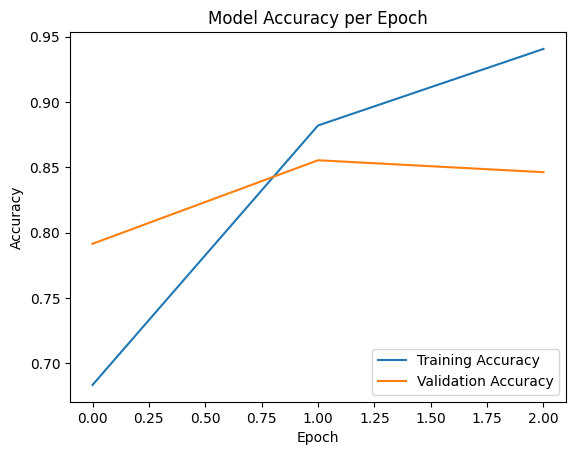

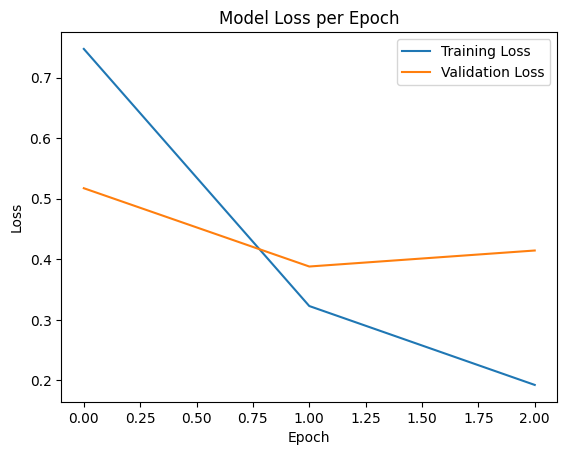

In [40]:
# Plot akurasi
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

In [38]:
# Prediksi emosi pada teks baru
new_texts = ["why this is happening to me", "I am so happy today", "im not sad, but happy"]
new_inputs = tokenizer(new_texts, return_tensors="tf", padding=True, truncation=True, max_length=128)

predictions = model.predict(new_inputs['input_ids'])
predicted_labels = label_encoder.inverse_transform(predictions.argmax(axis=1))

print(predicted_labels)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
['sad' 'happy' 'sad']


# BERT-CNN Model

In [23]:
from transformers import TFBertModel
from tensorflow.keras.callbacks import EarlyStopping

class BertLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(BertLayer, self).__init__(**kwargs)
        self.bert = TFBertModel.from_pretrained('bert-base-uncased')

    def call(self, inputs):
        input_ids, attention_mask = inputs
        outputs = self.bert(input_ids, attention_mask=attention_mask)
        return outputs[0]  # Mengambil output dari hidden states

def CNN_model():
    input_ids = tf.keras.layers.Input(shape=(128,), dtype=tf.int32, name='input_ids')  # Assuming a max length of 128
    attention_mask = tf.keras.layers.Input(shape=(128,), dtype=tf.int32, name='attention_mask')

    # Menggunakan layer khusus untuk BERT
    bert_outputs = BertLayer()([input_ids, attention_mask])

    # CNN layers
    network_layer = tf.keras.layers.Conv1D(32, (2), activation='relu')(bert_outputs)
    network_layer = tf.keras.layers.GlobalMaxPool1D()(network_layer)
    network_layer = tf.keras.layers.Dropout(0.5)(network_layer)
    network_layer = tf.keras.layers.Dense(3, activation="softmax", name='classifier')(network_layer)

    return tf.keras.Model(inputs=[input_ids, attention_mask], outputs=network_layer)

cnn_model = CNN_model()

# Define training parameters
steps_each_epoch = tf.data.experimental.cardinality(train_ds).numpy()
number_of_training_steps = steps_each_epoch * epochs_count
number_of_warmup_steps = int(0.1 * number_of_training_steps)


# Define loss and metrics
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)

# Using AdamW from TensorFlow
optimizer = tf.keras.optimizers.Adam(learning_rate=init_lr)

cnn_model.compile(optimizer=optimizer,
                  loss=loss,
                  metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')])  # Ubah metrics ke dalam list

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

print(f'Training BERT CNN model...')
cnn_history = cnn_model.fit(x=train_ds,
                            validation_data=val_ds,
                            epochs=epochs_count,
                            class_weight=class_weight_dict,
                            callbacks=[early_stop])

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Training BERT CNN model...
Epoch 1/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.3255 - loss: 2.8733 - val_accuracy: 0.3119 - val_loss: 2.5810
Epoch 2/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.3843 - loss: 2.6684 - val_accuracy: 0.3119 - val_loss: 2.4524
Epoch 3/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.3233 - loss: 2.5435 - val_accuracy: 0.3028 - val_loss: 2.3279
Epoch 4/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.3615 - loss: 2.3531 - val_accuracy: 0.3028 - val_loss: 2.2136
Epoch 5/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.3583 - loss: 2.5009 - val_accuracy: 0.2936 - val_loss: 2.1007
Epoch 6/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.3809 - loss: 2.2743 - val_accuracy: 0.3028 - val_loss: 1.9986
Epoch 7/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.3387 - loss: 2.2413 - val_accuracy: 0.2936 - val_loss: 1.9099
Epoch 8/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.2964 - loss: 2.2582 - val_a

In [ ]:
def CNN_model():
    input_ids = tf.keras.layers.Input(shape=(128,), dtype=tf.int32, name='input_ids') # Assuming a max length of 128
    attention_mask = tf.keras.layers.Input(shape=(128,), dtype=tf.int32, name='attention_mask')

    # BERT base uncased encoder
    bert_encoder = TFBertModel.from_pretrained('bert-base-uncased')
    # Convert KerasTensors to TensorFlow Tensors before passing to bert_encoder
    outputs = bert_encoder(input_ids.get(), attention_mask=attention_mask.get())
    network_layer = outputs[0]

    # CNN layers
    network_layer = tf.keras.layers.Conv1D(32, (2), activation='relu')(network_layer)
    network_layer = tf.keras.layers.GlobalMaxPool1D()(network_layer)
    network_layer = tf.keras.layers.Dropout(0.5)(network_layer)
    network_layer = tf.keras.layers.Dense(3, activation="softmax", name='classifier')(network_layer)

    return tf.keras.Model(inputs=[input_ids, attention_mask], outputs=network_layer)

In [24]:
# Predicting on test dataset
predictions = cnn_model.predict(test_ds)
y_pred = np.argmax(predictions, axis=-1)

print(classification_report(df_test.Label.values, y_pred))

15/15 ━━━━━━━━━━━━━━━━━━━━ 28s 2s/step
              precision    recall  f1-score   support

           0       0.33      0.94      0.49       152
           1       0.00      0.00      0.00       150
           2       0.41      0.08      0.13       154

    accuracy                           0.34       456
   macro avg       0.25      0.34      0.21       456
weighted avg       0.25      0.34      0.21       456



In [15]:
cnn_model.save('emo.h5')

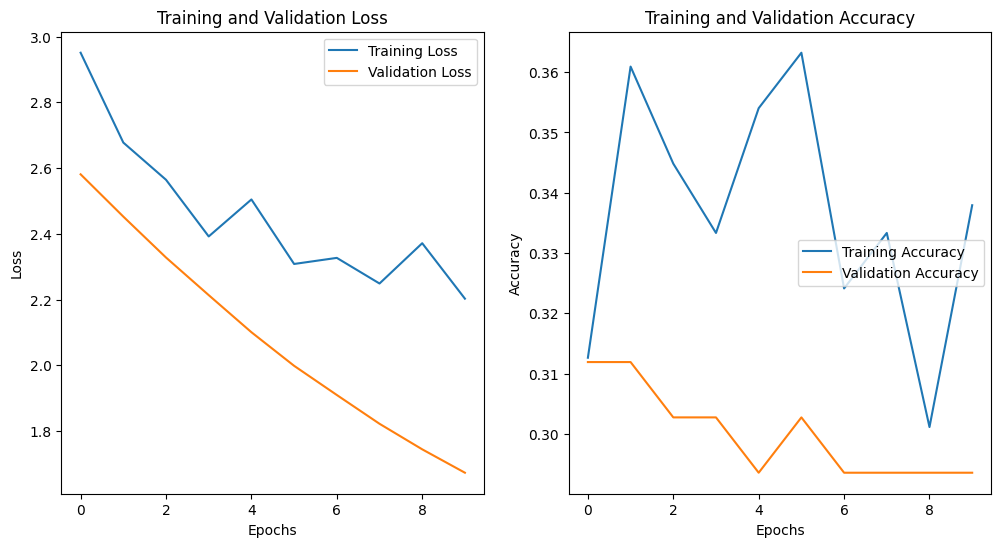

In [26]:
# Plot Training & Validation Loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(cnn_history.history['loss'], label='Training Loss')
plt.plot(cnn_history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot Training & Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(cnn_history.history['accuracy'], label='Training Accuracy')
plt.plot(cnn_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [17]:
def predict_emotion(text):
    # Tokenisasi dan encoding teks
    input_ids, attention_mask = encode_text(pd.DataFrame({'text': [text]}))
    
    # Melakukan prediksi
    predictions = cnn_model.predict((input_ids, attention_mask))
    predicted_class = np.argmax(predictions, axis=-1)
    
    # Mengembalikan label emosi
    emotion = label_encoder.inverse_transform(predicted_class)
    return emotion[0]

# Mengambil input dari pengguna
user_input = input("Masukkan teks untuk memprediksi emosinya: ")
predicted_emotion = predict_emotion(user_input)

print(f'Emosi yang terdeteksi: {user_input} : {predicted_emotion}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Emosi yang terdeteksi: Im sad : joy
